# Endoscopy Inbody Classification

This notebook shows how to fine tune an endoscopy inbody classification task with a pretrained model from the [monai model zoo](https://monai.io/model-zoo.html). The model is a binary classification model, which takes an image as input and a 0-1 digital implied whether the image's in-body or out-body as output.

Datasets used in this work were provided by Activ Surgical. 20 images (10 in-body and 10 out-body samples) are used to show how the pipeline works. And it's just an example of how to build the pipeline. A real classification dataset should be adopt if the model need to be transfered to new datasets.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, ignite, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Imports

In [2]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import torch


import monai
from monai.data import Dataset, Dataloader
from monai.visualize.utils import blend_images
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU
from monai.networks.nets import SEResNet50
from monai.transforms import (
        LoadImaged,
        ToTensord,
        AsChannelFirstd,
        Resized,
        CastToTyped,
        NormalizeIntensityd,
        EnsureTyped,
        RandRotated,
        RandScaleIntensityd,
        RandShiftIntensityd,
        RandGaussianNoised,
        RandFlipd,
)
from monai.utils import set_determinism
from monai.apps import download_url
from tqdm import trange
import zipfile

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.10.dev2236
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a803c6ba5a9e9829771547df7a7de05e4fd3b6d4
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
endo_dir = os.path.join(root_dir, "endo_cls")

/tmp/tmp4wun8ma6


## Download data

The data here are 20 images from Activ Surgical with 10 in-body images in "inbody" directory and 10 out-body images in "outbody" directory. 

In [4]:
set_url = r"https://drive.google.com/file/d/1rQQfHcZFs74OG0uJsL4vg7YqMWXV-s4k/view?usp=sharing"
set_path = os.path.join(endo_dir, "cls_set.zip")
#download_and_extract(set_url, set_path, endo_dir)
download_url(set_url, set_path)

You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1rQQfHcZFs74OG0uJsL4vg7YqMWXV-s4k
Downloading...
From: https://drive.google.com/file/d/1rQQfHcZFs74OG0uJsL4vg7YqMWXV-s4k/view?usp=sharing
To: /tmp/tmp6uj5qlba/cls_set.zip
70.6kB [00:00, 1.92MB/s]

2022-09-29 12:42:41,035 - INFO - Downloaded: /tmp/tmp4wun8ma6/endo_cls/cls_set.zip
2022-09-29 12:42:41,036 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp4wun8ma6/endo_cls/cls_set.zip.


## Transform, Dataset and Dataloader

In [13]:
import zipfile
from monai.data import Dataset, DataLoader
from monai.networks.nets import SEResNet50
from monai.transforms import (
        AsDiscrete,
        LoadImaged,
        Compose,
        ToTensord,
        AsChannelFirstd,
        Resized,
        CastToTyped,
        NormalizeIntensityd,
        EnsureTyped,
        RandRotated,
        RandScaleIntensityd,
        RandShiftIntensityd,
        RandGaussianNoised,
        RandFlipd,
)

In [32]:

with zipfile.ZipFile(set_path, 'r') as zr:
    zr.extractall(endo_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_sample_list(image_root):
    sample_list = []
    for root, _, filenames in os.walk(image_root):
        for filename in filenames:
            if ".jpg" in filename:
                image_path = os.path.join(root, filename)
                image_dir = os.path.basename(root)
                image_label = 0 if "inbody" in image_dir else 1
                sample_list.append({
                    "image": image_path,
                    "label": image_label,
                })
    return sample_list


image_root = os.path.join(endo_dir, "inbody_outbody_samples")
sample_list = get_sample_list(image_root)
inbody_list = sample_list[len(sample_list)//2:]
outbody_list = sample_list[:len(sample_list)//2]
print(f"There are total {len(sample_list)} samples")
train_sample_len = int(0.8 * len(sample_list)//2)
train_sample_list = inbody_list[:train_sample_len] + outbody_list[:train_sample_len]
val_sample_list = inbody_list[train_sample_len:] + outbody_list[train_sample_len:]
train_transform = Compose(
            [
                LoadImaged(keys=["image"]),
                ToTensord(keys=["label"]),
                AsChannelFirstd(keys=["image"]),
                Resized(keys=["image"], spatial_size=[256, 256], mode="bilinear"),
                CastToTyped(keys=["image"],dtype=torch.float32),
                NormalizeIntensityd(keys=["image"],nonzero=True, channel_wise=True),
                EnsureTyped(keys=["image"]),
                RandRotated(keys=["image"], range_x=0.3,prob=0.2, mode="bilinear"),
                RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.5),
                RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
                RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
                RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
                RandFlipd(keys=["image"], spatial_axis=1, prob=0.5),
            ]
        )

val_transform = Compose(
            [
                LoadImaged(keys=["image"]),
                ToTensord(keys=["label"]),
                AsChannelFirstd(keys=["image"]),
                Resized(keys=["image"], spatial_size=[256, 256], mode="bilinear"),
                CastToTyped(keys=["image", "label"],dtype=torch.float32),
                NormalizeIntensityd(keys=["image"],nonzero=True, channel_wise=True),
                EnsureTyped(keys=["image"]),
            ]
        ) 
train_dataset = Dataset(data=train_sample_list, transform=train_transform)
val_dataset = Dataset(data=val_sample_list, transform=val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

model = SEResNet50(spatial_dims=2, in_channels=3, num_classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

loss = torch.nn.CrossEntropyLoss(reduction="mean")
                      
post_trans= AsDiscrete(argmax=True, to_onehot=2)
post_label = AsDiscrete(argmax=False, to_onehot=2)



There are total 20 samples


## Check samples

Class 0.0
2022-09-29 14:48:41,246 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Class 0.0
2022-09-29 14:48:41,253 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Class 1.0
2022-09-29 14:48:41,259 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Class 1.0
2022-09-29 14:48:41,265 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


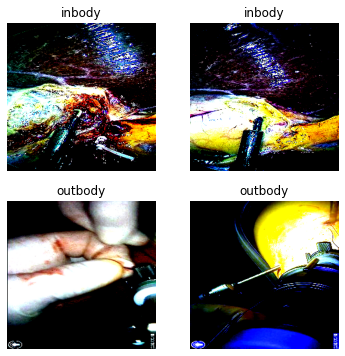

In [33]:
nrow, ncol = 2, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor='white')
nexamples = nrow * ncol
samples = sorted(np.random.choice(len(val_dataset), size=nexamples, replace=False))
for sample, ax in zip(samples, axes.flatten()):
    _ds = val_dataset[sample]
    img, lbl = _ds["image"], _ds["label"]
    blended = img
    class_type = "outbody" if lbl else "inbody"
    print(f"Class {lbl}")
    blended = np.moveaxis(blended, 0, -1)  # RGB to end
    ax.imshow(blended)
    ax.set_title(f"{class_type}")
    ax.axis("off")

## Do a classification training

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


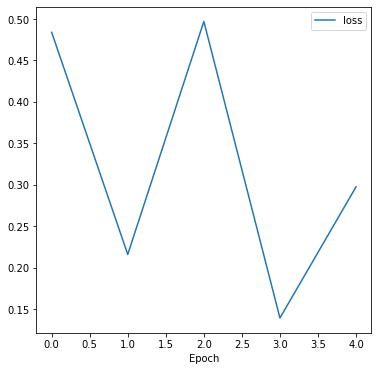

In [36]:
total_epoch = 5

model.train()
losses = []

for i in trange(total_epoch):
    epoch_loss = 0
    for data in train_dataloader:
        inputs, labels = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss_iter =loss(predictions, labels)
        loss_iter.backward()
        optimizer.step()
        epoch_loss += loss_iter.item()
    losses.append(epoch_loss/len(train_dataloader))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor="white")
ax.set_xlabel("Epoch")
epochs = list(range(len(losses)))
ax.plot(epochs, losses, label="loss")
plt.legend()
plt.show()
        